# CNN 모델 구현

In [1]:
# 시작 전에 GPU로 바꿔주기

In [3]:
# Google Drive 접근 = 구글 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 필요한 module import
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## ImageDataGenerator 만들기

In [5]:
# ImageDataGenerator 생성

#  dir 불러오기
train_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/train'
validation_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/valid'

# ImageDataGenerator를 생성(객체 생성)
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 객체 세부 설정
# 넌 이렇게 동작해야해! 라고 세부 세팅을 해준다

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

Found 380 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


## CNN 모델 구현 (pretrained-model : VGG16)

In [7]:
# Model을 만들어야 해요!
# Pretrained Network을 가져다가 사용할꺼예요!

from tensorflow.keras.applications import VGG16

pretrained_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
# Convolution Layer 동결
pretrained_model.trainable = False

model = Sequential()

# 우리 model에 pretrained network의 feature extraction을 가져다가 놓아요!
model.add(pretrained_model)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=3,
                activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16812867 (64.14 MB)
Trainable params: 2098179 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [25]:
# Model 학습 설정하고 학습을 진행

# model checkpoint 확인
model_cp = ModelCheckpoint(filepath='infantface_checkpoint.ckpt', # 임시로 제공 받은 runtime disk에 파일이 만들어진다. 계산된 가중치를 저장해놓자
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

# model earlystopping 확인(조기 종료는 언제할까요?)
model_es = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_generator,
                    steps_per_epoch=76, #train 총 이미지 나누기 5
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=12, #val 데이터 총 이미지 나누기 5
                    verbose=1,
                    callbacks=[model_cp, model_es])

model.save('./infantface_IDG_cnn_VGG16_model.h5')

Epoch 1/30
76/76 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7605
Epoch 1: val_loss improved from inf to 0.57634, saving model to infantface_checkpoint.ckpt
76/76 [==============================] - 6s 62ms/step - loss: 0.5635 - accuracy: 0.7605 - val_loss: 0.5763 - val_accuracy: 0.7500
Epoch 2/30
76/76 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7684
Epoch 2: val_loss improved from 0.57634 to 0.37963, saving model to infantface_checkpoint.ckpt
76/76 [==============================] - 4s 57ms/step - loss: 0.5697 - accuracy: 0.7684 - val_loss: 0.3796 - val_accuracy: 0.8833
Epoch 3/30
76/76 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.8000
Epoch 3: val_loss did not improve from 0.37963
76/76 [==============================] - 4s 56ms/step - loss: 0.4695 - accuracy: 0.8000 - val_loss: 0.3824 - val_accuracy: 0.8500
Epoch 4/30
76/76 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8263
E

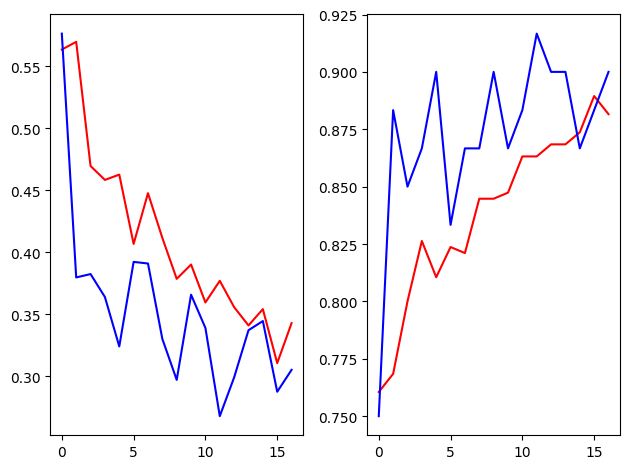

In [27]:
# 결과 그래프를 그려보아요!

import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

# Test

In [12]:
# 테스트에 필요한 module import
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [38]:
# 저장된 모델 파일의 경로
# saved_model_path = '/content/saved된 모델이름.h5' # model을 학습시킬 때 마지막에 model.save('저장된 모델 이름')코드 안에 있는 모델 이름을 적어주시면 됩니다
saved_model_path = '/content/infantface_IDG_cnn_VGG16_model.h5'

# 테스트할 이미지 경로 설정
test_image_path = '/content/drive/MyDrive/KOSA3/project/data/baby5.png'

# 모델 로드
loaded_model = load_model(saved_model_path)

# 이미지 불러오기 및 전처리
img = image.load_img(test_image_path, target_size=(150, 150)) # 위에서 우리가 저장한 target_size와 같은 크기로 주시면 돼요!
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # 경우에 따라 axis값이 달라집니다
img_array = preprocess_input(img_array)

In [39]:
# 모델 예측
predictions = loaded_model.predict(img_array)

# 예측 결과 해석 및 출력
class_indices = np.argmax(predictions, axis=1)

# 각 클래스의 인덱스에 따른 레이블 설정 (positive, neutral, negative)
class_labels = ['positive', 'neutral', 'negative']
predicted_label = class_labels[class_indices[0]]

print(f"Predicted Class: {predicted_label}")

1/1 [==============================] - 0s 143ms/step
Predicted Class: positive
